# Predicting Obesity Levels Based on Lifestyle and Demographic Factors Using Machine Learning
## Phase 2: Feature Selection and Machine Learning Model Development

**Author:** Tanjeena Tahrin Islam  
**Year:** 2025  
**Project Type:** Machine Learning   
**Programming Language:** Python  
**Tech Stack:** Python, NumPy, Pandas, Matplotlib, Seaborn, Scikit-learn, TensorFlow/Keras, SciPy  
**Dataset:** Obesity Prediction Dataset (UCI Machine Learning Repository)

# Introduction

## Phase-1 Summary

Phase 1 of this study was focused on data preparation and exploratory visualization. We selected the Obesity Prediction dataset from the UCI Machine Learning Repository, which contains 2,111 observations and 16 key features capturing demographic, lifestyle, and behavioral factors relevant to obesity and 1 target variable: obesity levels [1].

Several preprocessing steps were performed on the data, including checking the initial structure and summary statistics, identifying and handling missing values and outliers, and correcting mislabeled scale variables. Finally, exploratory analysis was conducted using histograms and bivariate plots to gain deeper insights into the data.

In [1]:
# Installations
!pip install --quiet tensorflow

In [2]:
#suppress warning messages
import warnings
warnings.filterwarnings("ignore")

# import packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif
from IPython.display import display, HTML
from tabulate import tabulate
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from scipy.stats import ttest_rel
from collections import defaultdict

pd.set_option('display.max_columns', None) #display all columns

In [3]:
# Preprocessed dataset imported
df_name = 'phase1_preprocessed.csv'
copy_df = pd.read_csv(df_name)

## Report Overview

The Phase 2 of this study is focused on applying various machine learning models to the preprocessed data prepared in Phase 1. This phase involves critical steps of predictive modeling, including feature selection, model development with hyperparameter tuning, fitting the best models, and evaluation. Four different classification algorithms — Logistic Regression, K-Nearest Neighbors (KNN), Random Forest, and Neural Network have been applied to the dataset. A comprehensive model comparison has been conducted to identify the model that most accurately represents and predicts the obesity levels in the data.

## Overview of Methodology

In this phase of the study, key steps included feature selection, hyperparameter tuning, model fitting, evaluation, and comparison.

#### Feature Selection
Variables causing multicollinearity were identified using a correlation matrix. Then, ANOVA F-scores were calculated to select the top 10 statistically significant features for model development. Features with higher ANOVA F-scores were retained.

#### Model Development:
Four classification algorithms were applied to the dataset: Logistic Regression, K-Nearest Neighbors (KNN), Random Forest, and Neural Network.

#### Hyperparameetr Tuning:
To optimize model parameters for better generalization and to avoid overfitting, grid search combined with cross-validation accuracy plots was used. 

#### Model Fitting:
Stratified k-fold cross-validation was employed to train the models using the tuned hyperparameters.

#### Model Evaluation: 
Performance metrics including accuracy, precision, recall, F1-score, and confusion matrices were calculated to assess each model’s effectiveness on different classes of the target variable.

#### Model Comparison: 
Paired t-tests were conducted to evaluate whether accuracy differences between models were statistically significant. Based on these results, accuracy comparisons were made across all models to identify the best-performing approach.

# Predictive Modelling

## Feature Selection

Feature selection is done by using correaltion matrix to remove multicolinearity and then a statistical method. However, before feature selelction, train-test split is done to avoid data leakage. 

### Train-Test Split

For testing, 30% of data is allocated, while 70% is kept for training.

In [4]:
# train-test split of dataset
X = copy_df.drop(columns=['NObeyesdad'])
y = copy_df['NObeyesdad']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Multicollinearity handling

The correlation matrix was used to identify variables causing multicollinearity. However, no variable was found to create any multicollinearity, so no variables were removed at this stage.

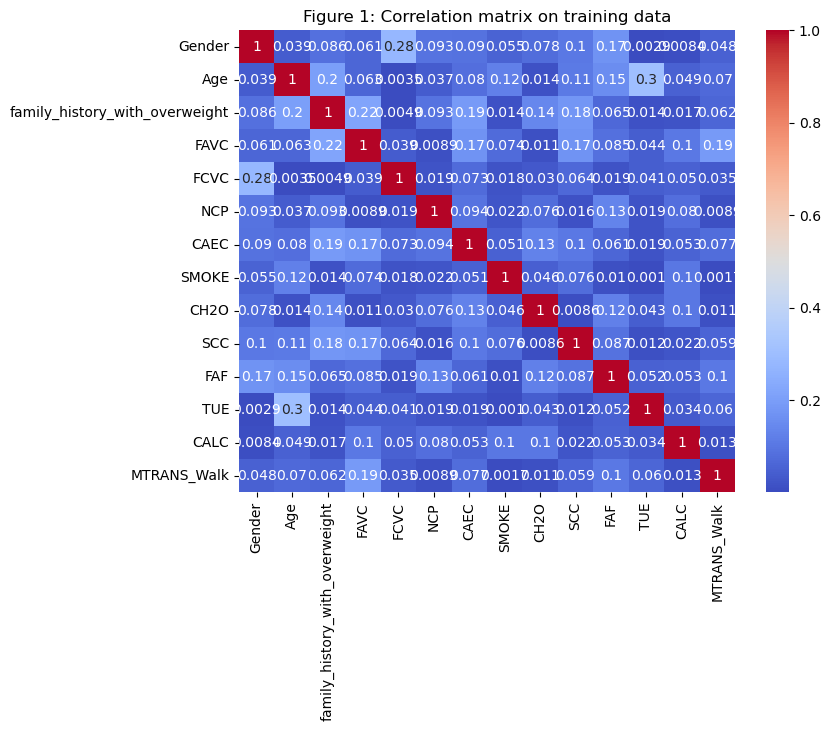

Feature dropped: None


In [5]:
# removing features creating multicollinearity
corr_matrix = X_train.corr().abs()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Figure 1: Correlation matrix on training data')
plt.show()

# identify features creating multicollinearity: if feature has correlation > 0.9
topTriangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
drop_features = [col for col in topTriangle.columns if any(topTriangle[col] > 0.9)]

print("Feature dropped:", drop_features if drop_features else None)
# No feature was dropped

### Feature Selection with ANOVA F-test

Next, we applied ANOVA F-test to select 10 features for all models. In this method, F-score for every feature has been calculated and top 10 features with the highest F-scores were selected. 

In [6]:
# 10 features selection using ANOVA F-test
selector10 = SelectKBest(score_func=f_classif, k=10)
X_train_final = selector10.fit_transform(X_train, y_train)

feature_scores = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': selector10.scores_,
    'p_Value': selector10.pvalues_
}).sort_values(by='F_Score', ascending=False)
print("\nAll Features ANOVA F-test Scores and p-values:")
print(feature_scores)

Features_selected = X_train.columns[selector10.get_support()]
X_test_final = selector10.transform(X_test)


All Features ANOVA F-test Scores and p-values:
                           Feature     F_Score        p_Value
0                           Gender  110.652998  2.847181e-115
2   family_history_with_overweight  102.607272  5.165077e-108
4                             FCVC   62.836382   1.512205e-69
6                             CAEC   62.744934   1.876938e-69
1                              Age   57.033496   1.538513e-63
3                             FAVC   28.069833   6.973183e-32
12                            CALC   26.071732   1.351255e-29
5                              NCP   16.288508   3.120524e-18
9                              SCC   14.651471   2.605351e-16
10                             FAF   12.962247   2.518609e-14
13                     MTRANS_Walk   12.845317   3.456288e-14
8                             CH2O   12.591800   6.864442e-14
11                             TUE    6.312021   1.443029e-06
7                            SMOKE    4.446431   1.815298e-04


In [7]:
Features_final = [
    ['Name', 'Data Type', 'Units', 'Description', 'Labels'],
    ['Gender', 'Nominal categorical', 'NA', 'Male or Female', "'Female': 0, 'Male': 1"],
    ['Age', 'Numeric', 'Years', 'The person’s age', 'NA'],
    ['family_history_with_overweight', 'Nominal categorical', 'NA', 'Family history of being overweight', "'no': 0, 'yes': 1"],
    ['FAVC', 'Nominal categorical', 'NA', 'Frequent consumption of high-calorie foods', "'no': 0, 'yes': 1"],
    ['FCVC', 'Ordinal categorical', 'Scale', 'Frequency of vegetable consumption (1 to 3)', 'NA'],
    ['NCP', 'Numeric', 'NA', 'Number of main meals per day', 'NA'],
    ['CAEC', 'Ordinal categorical', 'NA', 'Frequency of consuming food between meals', "'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3"],
    ['SCC', 'Nominal categorical', 'NA', 'Monitors calorie intake', "'no': 0, 'yes': 1"],
    ['FAF', 'Ordinal categorical', 'Scale', 'Physical activity frequency (0 to 3)', 'NA'],
    ['CALC', 'Ordinal categorical', 'NA', 'Frequency of alcohol consumption', "'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3"],
]

# display selected features
html_table = tabulate(Features_final, headers='firstrow', tablefmt='html')
styled_html = f"""
<div style="font-size: 11px; font-family: Cambria; overflow-x: auto;">
<b>Table 1: Selected features with summary</b><br>
<style>
    table {{
        border-collapse: collapse;
        table-layout: fixed;
    }}
    th, td {{
        border: 1px solid black !important;
        padding: 1px 2px;
        text-align: center !important;
        vertical-align: middle;
    }}
    table th {{
        background-color: #444444;  /* Dark gray background */
        color: white;               /* White text for contrast */
    }}
</style>
{html_table}
</div>
"""

display(HTML(styled_html))

Name,Data Type,Units,Description,Labels
Gender,Nominal categorical,NA,Male or Female,"'Female': 0, 'Male': 1"
Age,Numeric,Years,The person’s age,NA
family_history_with_overweight,Nominal categorical,NA,Family history of being overweight,"'no': 0, 'yes': 1"
FAVC,Nominal categorical,NA,Frequent consumption of high-calorie foods,"'no': 0, 'yes': 1"
FCVC,Ordinal categorical,Scale,Frequency of vegetable consumption (1 to 3),NA
NCP,Numeric,NA,Number of main meals per day,NA
CAEC,Ordinal categorical,NA,Frequency of consuming food between meals,"'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3"
SCC,Nominal categorical,NA,Monitors calorie intake,"'no': 0, 'yes': 1"
FAF,Ordinal categorical,Scale,Physical activity frequency (0 to 3),NA
CALC,Ordinal categorical,NA,Frequency of alcohol consumption,"'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3"


## Model Fitting & Tuning

### Logistic Regression

Best hyperparameters for logistic regression: {'C': 100.0, 'penalty': 'l1'}
Best cross-validation accuracy: 0.5531378836463582

Classification Report - Logistic Regression:
               precision    recall  f1-score   support

           0       0.48      0.49      0.48        86
           1       0.37      0.24      0.29        93
           2       0.45      0.33      0.38        88
           3       0.51      0.29      0.37        79
           4       0.49      0.61      0.54       102
           5       0.52      0.84      0.64        88
           6       0.90      0.99      0.94        98

    accuracy                           0.55       634
   macro avg       0.53      0.54      0.52       634
weighted avg       0.53      0.55      0.53       634



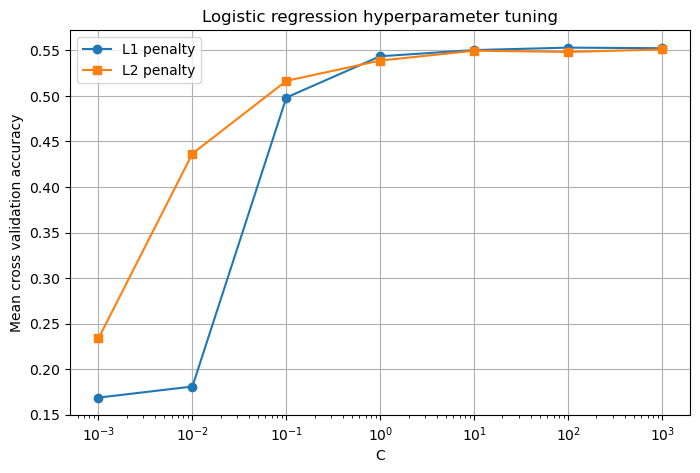

In [8]:
# logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear')

# hyperparameter grid for tuning
param_grid = {'C': np.logspace(-3, 3, 7), 'penalty': ['l1', 'l2']}

# set up GridSearchCV for tuning
grid_logreg = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# tuning
grid_logreg.fit(X_train_final, y_train)

print("Best hyperparameters for logistic regression:", grid_logreg.best_params_)
print("Best cross-validation accuracy:", grid_logreg.best_score_)

# evaluate best model on test set
y_pred_logreg = grid_logreg.predict(X_test_final) # predicted y using logistic regression
print("\nClassification Report - Logistic Regression:\n", classification_report(y_test, y_pred_logreg))

# model's performance with tuning hyperparameter C
results = grid_logreg.cv_results_
mean_test_scores = results['mean_test_score']
params = results['params']

# mean accuracy scores for L1 and L2 penalty
scores_l1 = [mean_test_scores[i] for i, p in enumerate(params) if p['penalty'] == 'l1']
scores_l2 = [mean_test_scores[i] for i, p in enumerate(params) if p['penalty'] == 'l2']
C_values = sorted(set(p['C'] for p in params if p['penalty'] == 'l1'))  # unique C value for both
# plot tuning results
plt.figure(figsize=(8,5))
plt.plot(C_values, scores_l1, marker='o', label='L1 penalty')
plt.plot(C_values, scores_l2, marker='s', label='L2 penalty')
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('Mean cross validation accuracy')
plt.title('Logistic regression hyperparameter tuning')
plt.legend()
plt.grid(True)
plt.show()

Hyperparameter tuning on the logistic regression model gave the best setting as C = 100. The accuracy was around 55.25%, which is quite low, meaning the model can only moderately separate different obesity level classes. The test set accuracy was also 55%, indicating that the model performs similarly on new data.

Obesity_Type_III class was predicted the best by this model, followed by Obesity_Type_II class. In contrast, Overweight_Level_I, Overweight_Level_II, and Obesity_Type_I classes had the poorest results. The remaining classes performed moderately well.

From the tuning plot, L1 regularization had lower accuracy compared to L2 until C = 1. After that point, their performances overlapped. This suggests that the regularization strength has a significant impact on model accuracy.

### K-Nearest Neighbors

Best hyperparameters for KNN: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best cross-validation accuracy: 0.7359665597801192

Classification Report - KNN:
               precision    recall  f1-score   support

           0       0.66      0.80      0.73        86
           1       0.52      0.35      0.42        93
           2       0.73      0.62      0.67        88
           3       0.61      0.57      0.59        79
           4       0.65      0.69      0.67       102
           5       0.73      0.89      0.80        88
           6       0.94      0.99      0.97        98

    accuracy                           0.71       634
   macro avg       0.69      0.70      0.69       634
weighted avg       0.70      0.71      0.70       634



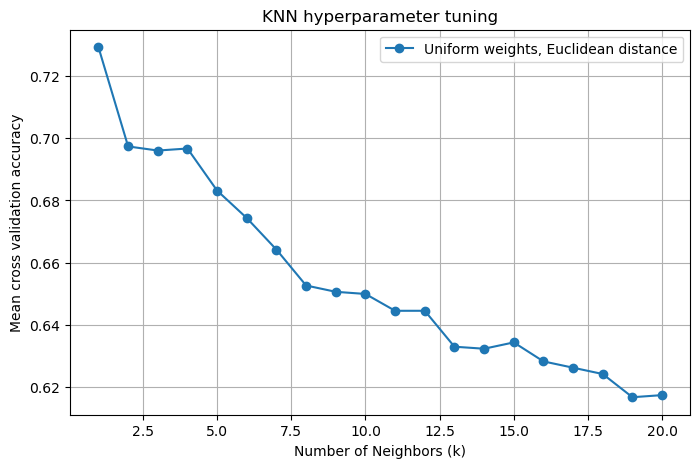

In [9]:
# KNN classifier without setting hyperparameters
knn_classifier = KNeighborsClassifier()
# grid of hyperparameters
param_grid_knn = {
    'n_neighbors': list(range(1, 21)), 
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 = Manhattan distances, and 2 = Euclidean distances
}
# Grid Search cross-validation over grid, 5-fold cross validation
grid_knn = GridSearchCV(knn_classifier, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1)
grid_knn.fit(X_train_final, y_train)

print("Best hyperparameters for KNN:", grid_knn.best_params_)
print("Best cross-validation accuracy:", grid_knn.best_score_)
# best model for prediciton
y_pred_knn = grid_knn.predict(X_test_final) # predicted y using KNN
print("\nClassification Report - KNN:\n", classification_report(y_test, y_pred_knn))

# plot tuning results for n_neighbors considering weights = 'uniform' and p = 2
results_knn = grid_knn.cv_results_
mean_test_scores_knn = results_knn['mean_test_score'] # average(accuracy of cross validation folds)
params_knn = results_knn['params']
# scores for each k to be plotted
neighbors = range(1, 21)
scores_uniform = [mean_test_scores_knn[i] for i, p in enumerate(params_knn) if p['weights'] == 'uniform' and p['p'] == 2]  # Euclidean distance
# plot
plt.figure(figsize=(8,5))
plt.plot(neighbors, scores_uniform, marker='o', label='Uniform weights, Euclidean distance')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Mean cross validation accuracy')
plt.title('KNN hyperparameter tuning')
plt.legend()
plt.grid(True)
plt.show()

Hyperparameter tuning on the KNN model gave us the best parameters: n_neighbors = 4, p = 1 (Manhattan distance), and weights = 'distance'. With this configuration, we achieved a cross-validation accuracy of around 70.89%. The test accuracy was a bit lower, 68%, but this is a good generalization.

Among all classes, Obesity_Type_III performed the best, while Normal_Weight performed the poorest. Most other classes showed moderate F1-scores.

We also explored a setup using Euclidean distance and uniform weights, where k = 1 gave the highest cross-validation accuracy. Accuracy became more stable around k = 3 or 4, but started to drop after k = 5.

### Random Forest

Best hyperparameters for Random Forest: {'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 200}
Best cross-validation accuracy: 0.7813215758131011

Classification Report - Random Forest:
               precision    recall  f1-score   support

           0       0.73      0.79      0.76        86
           1       0.55      0.56      0.55        93
           2       0.77      0.60      0.68        88
           3       0.64      0.68      0.66        79
           4       0.75      0.71      0.73       102
           5       0.82      0.91      0.86        88
           6       0.98      0.99      0.98        98

    accuracy                           0.75       634
   macro avg       0.75      0.75      0.75       634
weighted avg       0.75      0.75      0.75       634



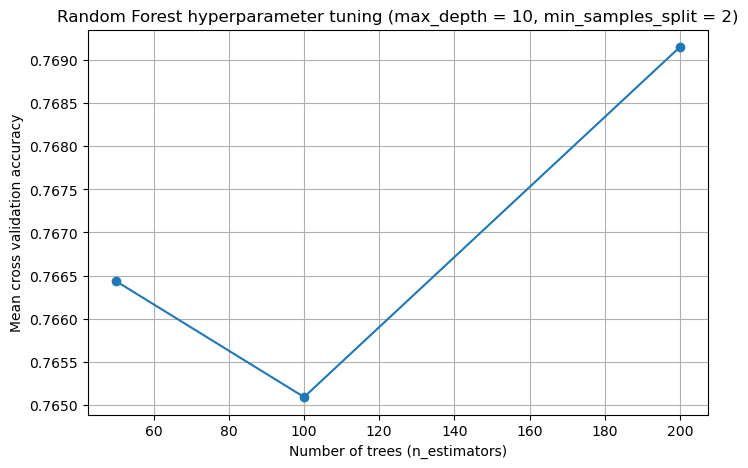

In [10]:
# Random Forest classifier
rf = RandomForestClassifier(random_state=42)
# setting grid of parameters for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}
# tuning
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_rf.fit(X_train_final, y_train)

print("Best hyperparameters for Random Forest:", grid_rf.best_params_)
print("Best cross-validation accuracy:", grid_rf.best_score_)

y_pred_rf = grid_rf.predict(X_test_final) # prediction using Random Forest
print("\nClassification Report - Random Forest:\n", classification_report(y_test, y_pred_rf))

# plot tuning results for n_estimators 
    # max_depth = 10
    # min_samples_split = 2
results_rf = grid_rf.cv_results_
mean_test_scores_rf = results_rf['mean_test_score']
params_rf = results_rf['params']

# scores with max_depth = 10 and min_samples_split = 2
n_estimators_list = [50, 100, 200]
scores_n_estimators = []
for n in n_estimators_list:
    for i, p in enumerate(params_rf):
        if p['n_estimators'] == n and p['max_depth'] == 10 and p['min_samples_split'] == 2:
            scores_n_estimators.append(mean_test_scores_rf[i])
            break # break when conditions match
# plot of tuning results
plt.figure(figsize=(8,5))
plt.plot(n_estimators_list, scores_n_estimators, marker='o')
plt.xlabel('Number of trees (n_estimators)')
plt.ylabel('Mean cross validation accuracy')
plt.title('Random Forest hyperparameter tuning (max_depth = 10, min_samples_split = 2)')
plt.grid(True)
plt.show()

The best hyperparameters for random forest model were max_depth=None, min_samples_split=5, and n_estimators=200. Using these, the model achieved a cross-validation accuracy of around 76.8%. The test accuracy was similar, 74%, indicating strong generalization.

Similar to the other models, Obesity_Type_III performed very well, while Normal_Weight had the weakest performance. Obesity_Type_II showed a high recall of 0.90, meaning most instances were correctly identified. The F1-scores across classes ranged from 0.53 to 0.98, suggesting moderate performance, with possible class overlap.

In the tuning plot (for a fixed setup: max_depth=10, min_samples_split=2), using 100 trees gave the highest accuracy.

### Neural Network

A neural network (NN) model was developed in this study to perform multi-class classification on the obesity dataset, with the objective of categorising individuals into one of seven obesity-related classes. The NN was built using TensorFlow and Keras, and its performance was optimised through a structured hyperparameter tuning process.

#### Architecture and Topology
The final neural network architecture consists of the following components:
1. The model accepts 10 input features, selected using prior feature selection techniques that aimed to retain the most informative variables.
2. The first hidden layer contains 128 neurons and uses the Rectified Linear Unit (ReLU) activation function
3. To reduce overfitting, a dropout rate of 0.1 is applied after the first hidden layer. This technique randomly disables 10% of the neurons during training, promoting generalisation by preventing co-adaptation of feature detectors.
4. A second hidden layer with 32 neurons is also there, again using the ReLU activation function to further transform and abstract the input data.
5. The output layer consists of 7 neurons, each corresponding to one of the obesity categories. A softmax activation function is used to generate class probabilities for multi-class classification.
6. The model's performance was evaluated using the accuracy metric, both during training and on the unseen test data, and the metrices have been compared to identify genelization. 

#### Hyperparameter Tuning
Five key hyperparameters were individually tuned using a grid search strategy, with training conducted on a scaled dataset (70% training / 30% validation split). The hyperparameters and their tested values were as follows:
* Learning Rate: [0.01, 0.001, 0.0001]
* Dropout Rate: [0.1, 0.3, 0.5]
* Batch Size: [16, 32, 64]
* Neurons in First Hidden Layer: [32, 64, 128]
* Number of Epochs: [20, 50, 100]

Each hyperparameter was tuned independently, with other values held constant. Through experimentation, the best-performing configuration was identified as follows:
Learning rate: 0.01, dropout rate: 0.1, batch size: 32, neurons in 1st layer: 128 and epochs: 20

This configuration yielded the highest validation accuracy and demonstrated the lowest overfitting tendency across all tuning runs. As evidenced by the corresponding training plots, these values produced a model that balanced generalisation and performance effectively on this dataset.

Training with learning_rate=0.01
Training with learning_rate=0.001
Training with learning_rate=0.0001
Training with dropout_rate=0.1
Training with dropout_rate=0.3
Training with dropout_rate=0.5
Training with batch_size=16
Training with batch_size=32
Training with batch_size=64
Training with neurons_layer1=32
Training with neurons_layer1=64
Training with neurons_layer1=128
Training with epochs=20
Training with epochs=50
Training with epochs=100


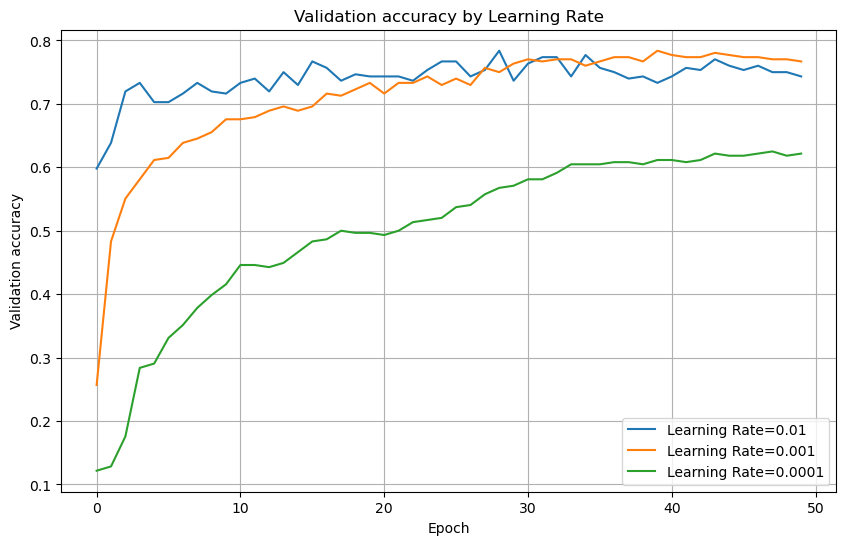

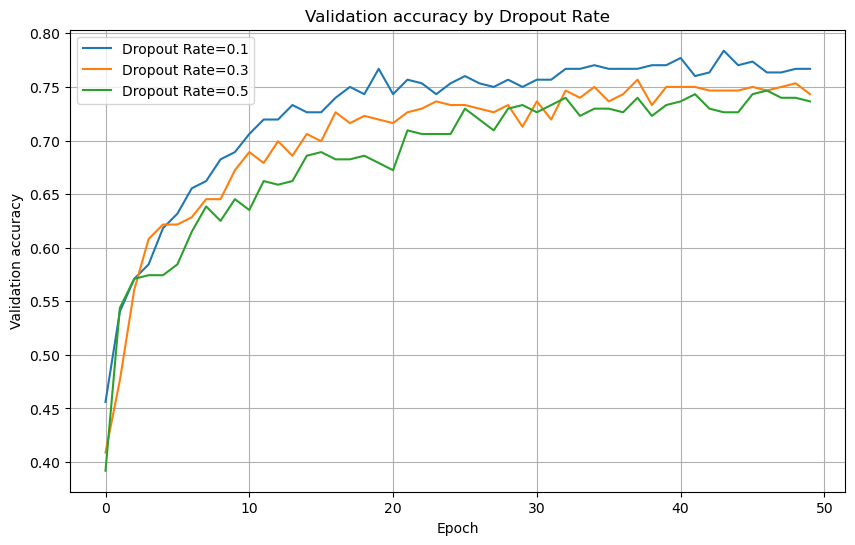

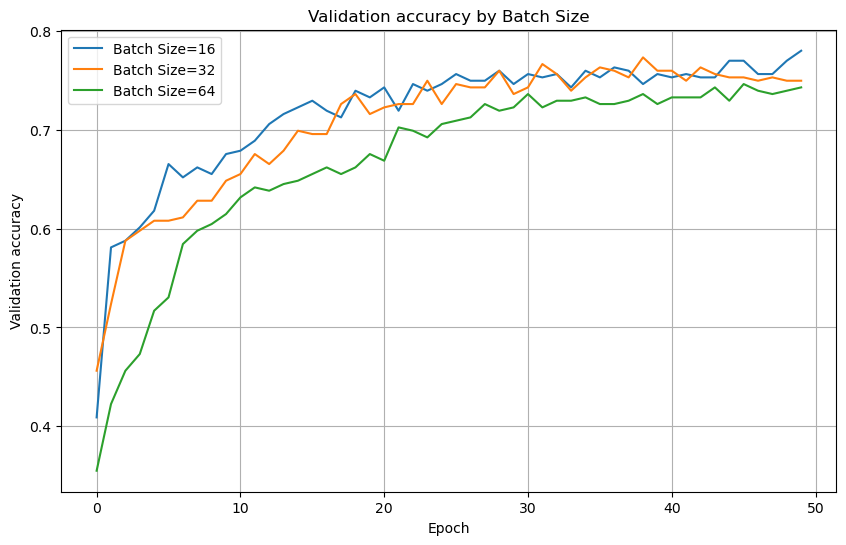

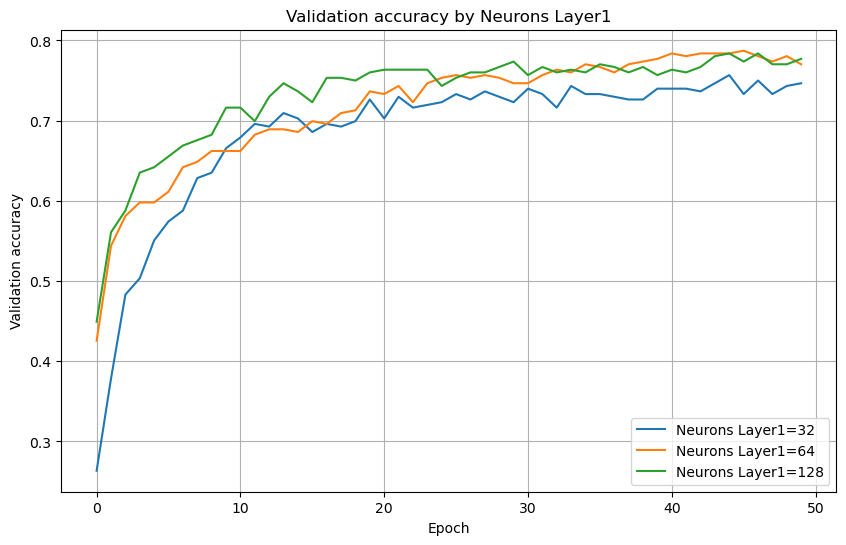

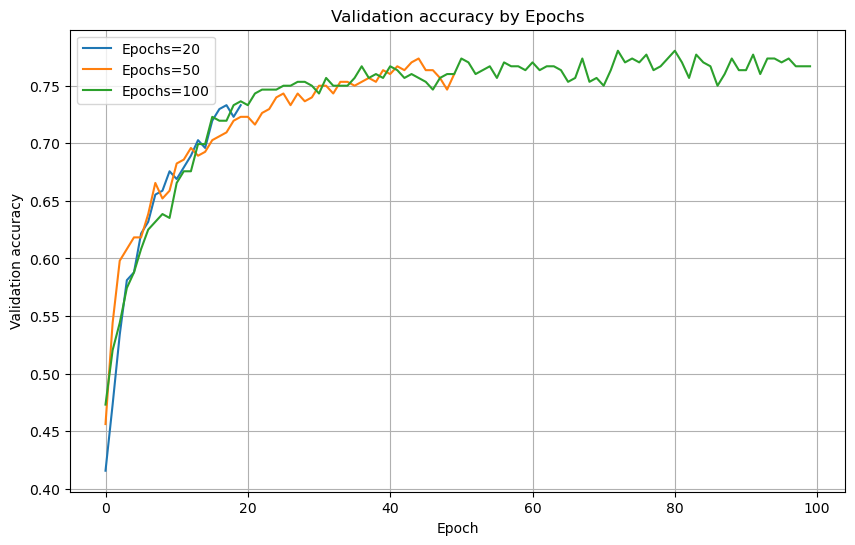

In [15]:
input_dim = 10 # since we performed feature selection to get 10 features
num_classes = 7 # target variable has 7 classes

# feature scaling: standardize features to mean=0 and variance=1
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)

# base model function: NN Architecture
    # optimization algorithm: adaptive moment estimation
    # error compute: sparse_categorical_crossentropy
    # accuracy score 

def build_model(input_dim, num_classes, learning_rate=0.001, dropout_rate=0.3, neurons_layer1=64):
    model = Sequential()
    model.add(Dense(neurons_layer1, input_dim=input_dim, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # softmax for multi-class
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
    
# set hyperparameters for tuning
learning_rates = [0.01, 0.001, 0.0001]
dropout_rates = [0.1, 0.3, 0.5]
batch_sizes = [16, 32, 64]
neurons_layer1_options = [32, 64, 128]
epoch_options = [20, 50, 100]

# initial values 
histories = {}

# Five NN hyperparameters and fine-tuning plots #
# START #

## 1) learning rate
for lr in learning_rates:
    print(f"Training with learning_rate={lr}")
    model = build_model(input_dim, num_classes, learning_rate=lr)
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    histories[f'Learning Rate={lr}'] = history

# 2) dropout rate
for dr in dropout_rates:
    print(f"Training with dropout_rate={dr}")
    model = build_model(input_dim, num_classes, dropout_rate=dr)
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    histories[f'Dropout Rate={dr}'] = history

# 3) batch size
for bs in batch_sizes:
    print(f"Training with batch_size={bs}")
    model = build_model(input_dim, num_classes)
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=bs,
        verbose=0
    )
    histories[f'Batch Size={bs}'] = history

# 4) neurons in 1st layer
for n1 in neurons_layer1_options:
    print(f"Training with neurons_layer1={n1}")
    model = build_model(input_dim, num_classes, neurons_layer1=n1)
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=32,
        verbose=0
    )
    histories[f'Neurons Layer1={n1}'] = history

# 5) number of epochs
for ep in epoch_options:
    print(f"Training with epochs={ep}")
    model = build_model(input_dim, num_classes)
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=ep,
        batch_size=32,
        verbose=0
    )
    histories[f'Epochs={ep}'] = history

# plots of hyperparameters tuning
grouped_histories = defaultdict(dict)

# group histories by hyperparameter type
for label, history in histories.items():
    key, value = label.split('=')
    grouped_histories[key.strip()][value.strip()] = history

# plots
for hyperparam, variations in grouped_histories.items():
    plt.figure(figsize=(10, 6))
    for value, history in variations.items():
        plt.plot(history.history['val_accuracy'], label=f'{hyperparam}={value}')
    plt.title(f'Validation accuracy by {hyperparam}')
    plt.xlabel('Epoch')
    plt.ylabel('Validation accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

From 5 different hyperparameters tuning plots, the best-performing hyperparameters that consistently gave the highest accuracy were: learning rate = 0.01, dropout rate = 0.1, batch size = 32, neurons in layer 1 = 128, and epochs = 20. The model has been fitted with these parameters.

Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.4379 - loss: 1.5310 - val_accuracy: 0.6453 - val_loss: 0.9633
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6441 - loss: 0.9772 - val_accuracy: 0.7027 - val_loss: 0.8794
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6756 - loss: 0.8911 - val_accuracy: 0.7331 - val_loss: 0.7868
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6807 - loss: 0.8426 - val_accuracy: 0.7264 - val_loss: 0.7743
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7220 - loss: 0.7845 - val_accuracy: 0.7095 - val_loss: 0.7942
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7192 - loss: 0.7588 - val_accuracy: 0.7297 - val_loss: 0.7566
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7323 - loss: 0.7181 - val_accuracy: 0.7196 - val_loss: 0.7883
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7449 - loss: 0.7186 - val_accuracy: 0.7128 - val_loss

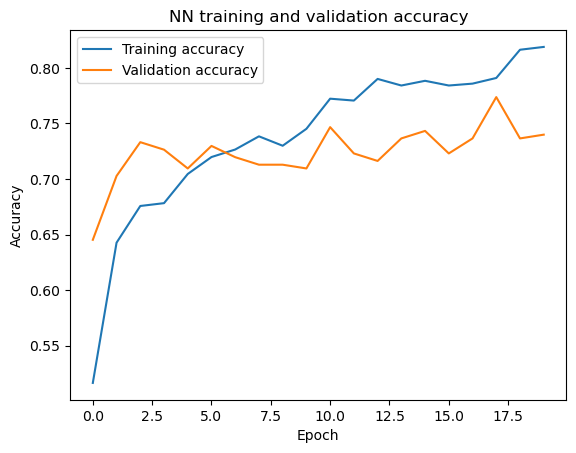

In [16]:
# model with best hyperparameters
best_model = build_model(input_dim, num_classes, learning_rate=0.01, dropout_rate=0.1, neurons_layer1=128)
best_history = best_model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

test_loss, test_acc = best_model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Test accuracy of best model: {test_acc:.4f}")
# predict classes on test data
y_pred_prob_nn  = best_model.predict(X_test_scaled)
y_pred_nn = y_pred_prob_nn.argmax(axis=1)  # for multi-class classification

print("\nClassification Report - Neural Network:\n", classification_report(y_test, y_pred_nn))
# plot of training & validation accuracy
plt.plot(best_history.history['accuracy'], label='Training accuracy')
plt.plot(best_history.history['val_accuracy'], label='Validation accuracy')
plt.title('NN training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

The best setup of the neural network achieved an overall accuracy of about 69%. The model performed well on classes Obesity_Type_II and Obesity_Type_III like other models, but struggled with Normal_Weight, which had low recall and was often missed.

The plot displayed early underfitting (validation accuracy > training accuracy) and later overfitting (validation accuracy < training accuracy) with a match at epoch ~ 7.

## Model Comparison

This section compares the performance of three machine learning models—Random Forest, K-Nearest Neighbors (KNN), and Logistic Regression—based on their accuracy. A paired t-test was conducted to assess whether the differences in model accuracies are statistically significant or not.

### Accuracy comparison

In [17]:
accuracy_all = {
    "Model": ["Logistic Regression", "K-Nearest Neighbors", "Random Forest"],
    "Accuracy": [0.5525, 0.7089, 0.7685]  
}

accuracy_df = pd.DataFrame(accuracy_all)
print(accuracy_df)

                 Model  Accuracy
0  Logistic Regression    0.5525
1  K-Nearest Neighbors    0.7089
2        Random Forest    0.7685


According to accuracy, Random Forest performed best, followed by KNN, and Logistic Regression.

In [18]:
# best models (already trained & tuned)
best_logreg = grid_logreg.best_estimator_
best_knn = grid_knn.best_estimator_
best_rf = grid_rf.best_estimator_

# 5-fold cross-validation accuracies
scores_logreg = cross_val_score(best_logreg, X_train_final, y_train, cv=5, scoring='accuracy')
scores_knn = cross_val_score(best_knn, X_train_final, y_train, cv=5, scoring='accuracy')
scores_rf = cross_val_score(best_rf, X_train_final, y_train, cv=5, scoring='accuracy')

# Define paired comparisons
ttest_pairs = [
    ('LogReg vs KNN', scores_logreg, scores_knn),
    ('LogReg vs RF', scores_logreg, scores_rf),
    ('KNN vs RF', scores_knn, scores_rf),
]

# Perform paired t-tests and collect results
results = {"Comparison": [], "t-stat": [], "p-value": [], "Significance": []}

for name, a, b in ttest_pairs:
    t, p = ttest_rel(a, b)
    results["Comparison"].append(name)
    results["t-stat"].append(round(t, 4))
    results["p-value"].append(round(p, 4))
    results["Significance"].append("Significant" if p < 0.05 else "Not Significant")

df_results = pd.DataFrame(results)

print("Paired t-test Results")
print(df_results.to_string(index=False))

Paired t-test Results
   Comparison   t-stat  p-value Significance
LogReg vs KNN -10.7135   0.0004  Significant
 LogReg vs RF -24.3760   0.0000  Significant
    KNN vs RF  -3.6583   0.0216  Significant


Based on paired t-test results which indicated that all accuracies were significantly different in models, Random Forest with the highest accuracy was the best performing model on obesity data.

# Critique & Limitations

## Strengths

* Logistic Regression model’s sparsity and efficiency improved after applying regularization through hyperparameter tuning.
* Logistic Regression model demonstrated consistent performance across classes.
* K-Nearest Neighbors (KNN) and Random Forest models delivered reasonably good performance, with Random Forest performing the best among the models evaluated.
* The Obesity_Type_III and Obesity_Type_II classes were classified with high precision.
* Random Forest model performed well in the multiclass classification task, maintaining a balanced macro F1-score above 70%.

## Limitaions

* Across all models, poor performance was observed on the classes Normal_Weight, Overweight_Level_I, and Overweight_Level_II.
* limited feature selection was used, which may have contributed to poor performance for certain target classes. 
* Logistic rregresion did not performed well overall, haivng only 55% accuracy, probably due to its assumption of linear relationships, whereas the true relationships between variables may be more complex.
* Regularization tuning on logistic regrsion suggested that weak regularization performed best which may have resulted in overfitting.

## Recommendations

* Advanced feature selection methods can be applied to improve model performance.
* Instead of Logistic Regression, models capable of capturing complex non-linear relationships—such as Decision Trees, or Gradient Boosting can be considered.

# Summary & Conclusions

## Project Summary

The project focused on predicting levels of obesity based on various demographic and lifestyle variables. The dataset used was the Obesity Prediction dataset from the UCI Machine Learning Repository, consisting of 2,111 observations and 17 variables—including one target variable representing obesity levels and 16 feature variables. The study was conducted in two phases.

In Phase 1, data preprocessing was performed to ensure the dataset was suitable for predictive modeling. This included checking for inconsistent scale values, handling missing values and outliers, and applying label encoding to convert categorical variables into numeric format. Basic descriptive analysis was conducted, including visualizations of individual variables (histograms) and bivariate plots, to understand data distribution and relationships between features. Additionally, a literature review on existing machine learning models for obesity prediction informed key preprocessing decisions—such as identifying important features, removing redundant or highly correlated variables, and deciding on new variable creation from old variable.  

Phase 2 focused on applying and comparing different machine learning algorithms to predict the multi-class target variable—obesity level. Four classification models were implemented: Logistic Regression, K-Nearest Neighbors (KNN), Random Forest (RF), and Neural Network (NN). Feature selection was carried out using correlation matrices to identify multicollinearity and ANOVA F-scores to select the top 10 statistically significant features.

Hyperparameter tuning was done using grid search combined with stratified k-fold cross-validation to improve model performance and avoid overfitting. Each model was evaluated using performance metrics such as accuracy, precision, recall, F1-score, and confusion matrix. Finally, paired t-tests were used to compare the classification models statistically, and the best-performing model was identified based on accuracy and significance of differences.

## Summary of Findings

Among the four classification models tested, Random Forest and Neural Network generally demonstrated higher accuracy and better overall predictive performance compared to Logistic Regression and K-Nearest Neighbors. Paired t-tests confirmed that differences in accuracy between some models were statistically significant, supporting the selection of the best-performing model for this dataset.

## Conclusions

The project successfully identified the Random Forest model, with tuned hyperparameters, as the most effective classifier for predicting obesity levels from the dataset. After thorough data preprocessing, feature selection, and model optimization, Random Forest outperformed Logistic Regression, K-Nearest Neighbors, and Neural Network models. This confirms that a combination of demographic, health, and lifestyle variables can reliably predict obesity levels. However, to enhance predictive performance further, additional feature engineering and inclusion of more relevant variables are recommended.

# References

[1] Adeniran, S. (n.d.). Obesity Prediction Dataset. Kaggle. https://www.kaggle.com/datasets/adeniranstephen/obesity-prediction-dataset